In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = 'drive/My Drive/Sign-Language-Digits-Dataset-master'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Dataset")
print(classes)

['LICENSE', 'README.md', 'Dataset', 'Examples']
['9', '8', '4', '6', '0', '7', '2', '5', '1', '3']


In [ ]:
dataset = ImageFolder(data_dir+'/Dataset', transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(64), torchvision.transforms.ToTensor()]))

In [ ]:
val_size = int(0.05*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1959, 103)

In [ ]:
print(train_size)
test_size=50
train_size = len(train_ds) - test_size

train_ds, test_ds = random_split(train_ds, [train_size, test_size])
len(train_ds), len(test_ds)

1959


(1909, 50)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class SignLangCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.relu2 = nn.ReLU()
#         self.max1 = nn.MaxPool2d(2, 2) # output: 64 x 32X32

#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.relu3 = nn.ReLU()
#         self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
#         self.relu4 = nn.ReLU()
#         self.max2 = nn.MaxPool2d(2, 2) # output: 128 x 16 x 16

#         # self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
#         # self.relu5 = nn.ReLU()
#         # self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
#         # self.relu6 = nn.ReLU()
#         # self.max3 = nn.MaxPool2d(2, 2)
#         # nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#         # nn.ReLU(),
#         # nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#         # nn.ReLU(),
#         # nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

#         self.flat = nn.Flatten()
#         self.lin1 = nn.Linear(4096, 2048)
#         self.relu7 = nn.ReLU()
#         self.lin2 = nn.Linear(2048, 1024)
#         self.relu8 = nn.ReLU()
#         # self.lin3 = nn.Linear(4096, 2048)
#         # self.relu9 = nn.ReLU()
#         self.lin4 = nn.Linear(1024, 10)


        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.max1 = nn.MaxPool2d(4, 4) # output: 64 x 32X32

        # self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # self. relu3 = nn.ReLU()
        # self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.relu4 = nn.ReLU()
        # self.max2 = nn.MaxPool2d(4, 4) # output: 128 x 16 x 16

        # self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        # self.relu5 = nn.ReLU()
        # self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        # self.relu6 = nn.ReLU()
        # self.max3 = nn.MaxPool2d(2, 2) # output: 256 x 8 x 8

        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(16384, 512)
        self.relu7 = nn.ReLU()
        self.lin2 = nn.Linear(512, 10)
        # self.relu8 = nn.ReLU()
        # self.lin3 = nn.Linear(1024, 10)

    def forward(self, xb):
        outs = None
        outs = self.conv1(xb)
        outs = self.relu1(outs)
        outs = self.conv2(outs)
        outs = self.relu2(outs)
        outs = self.max1(outs)

        # outs = self.conv3(outs)
        # outs = self.relu3(outs)
        # outs = self.conv4(outs)
        # outs = self.relu4(outs)
        # outs = self.max2(outs)

        # outs = self.conv5(outs)
        # outs = self.relu5(outs)
        # outs = self.conv6(outs)
        # outs = self.relu6(outs)
        # outs = self.max3(outs)

#         outs = self.flat(outs)
#         # print(outs.shape)
#         outs = self.lin1(outs)
#         outs = self.relu7(outs)
#         outs = self.lin2(outs)
#         outs = self.relu8(outs)
#         # outs = self.lin3(outs)
#         # outs = self.relu9(outs)
#         outs = self.lin4(outs)



#         outs = self.conv6(outs)
#         outs = self.relu6(outs)
#         outs = self.conv7(outs)
#         outs = self.relu7(outs)
#         outs = self.max3(outs)

        outs = self.flat(outs)
        # print(outs.shape)
        outs = self.lin1(outs)
        outs = self.relu7(outs)
        outs = self.lin2(outs)
        # outs = self.relu8(outs)
        # outs = self.lin3(outs)
        # outs = self.network(xb)
        return outs

In [ ]:
model = SignLangCnnModel()
model

SignLangCnnModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (max1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=16384, out_features=512, bias=True)
  (relu7): ReLU()
  (lin2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.0005

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.302690267562866, 'val_acc': 0.11650485545396805}

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.3001, val_loss: 2.2206, val_acc: 0.2718
Epoch [1], train_loss: 2.0595, val_loss: 1.8603, val_acc: 0.4272
Epoch [2], train_loss: 1.4501, val_loss: 1.2320, val_acc: 0.6311
Epoch [3], train_loss: 0.8978, val_loss: 0.8679, val_acc: 0.7184
Epoch [4], train_loss: 0.6344, val_loss: 0.7756, val_acc: 0.7573
Epoch [5], train_loss: 0.5061, val_loss: 0.7045, val_acc: 0.7573
Epoch [6], train_loss: 0.4297, val_loss: 0.6144, val_acc: 0.7670
Epoch [7], train_loss: 0.3582, val_loss: 0.5329, val_acc: 0.8058
Epoch [8], train_loss: 0.2981, val_loss: 0.4648, val_acc: 0.8252
Epoch [9], train_loss: 0.2701, val_loss: 0.4092, val_acc: 0.8350
Epoch [10], train_loss: 0.2313, val_loss: 0.4241, val_acc: 0.8350
Epoch [11], train_loss: 0.1878, val_loss: 0.3907, val_acc: 0.8544
Epoch [12], train_loss: 0.1583, val_loss: 0.4264, val_acc: 0.8350
Epoch [13], train_loss: 0.1462, val_loss: 0.3316, val_acc: 0.8738
Epoch [14], train_loss: 0.1177, val_loss: 0.3730, val_acc: 0.8447


In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.3640905022621155, 'val_acc': 0.8799999952316284}

In [ ]:
x = np.arange(0, 15, 1).tolist()
train_loss = [2.3001, 2.0595, 1.4501, 0.8978, 0.6344, 0.5061, 0.4297, 0.3582, 0.2981, 0.2701, 0.2313, 0.1878, 0.1583, 0.1462, 0.1177]
val_loss = [2.2206, 1.8603, 1.2320, 0.8679, 0.7756, 0.7045, 0.6144, 0.5329, 0.4648, 0.4092, 0.4241, 0.3907, 0.4264, 0.3316, 0.3730]

In [ ]:
from google.colab import files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

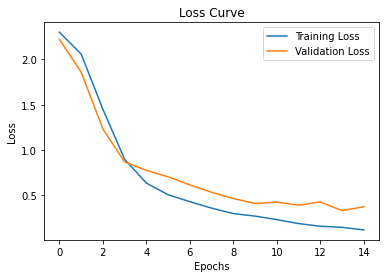

In [ ]:
fig = plt.figure()
plt.plot(x, train_loss, label = 'Training Loss')
plt.plot(x, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Curve")
plt.legend()
plt.savefig('lossCurveDigits.svg')
files.download('lossCurveDigits.svg')
plt.show()

In [ ]:
torch.save(model, 'drive/My Drive/Sign-Language-Digits-Dataset-master/model.pt')
# torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
model = torch.load('drive/My Drive/Sign-Language-Digits-Dataset-master/model.pt')

In [ ]:
model

SignLangCnnModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (max1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=16384, out_features=512, bias=True)
  (relu7): ReLU()
  (lin2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
val_acc = [0.2718, 0.4272, 0.6311, 0.7184, 0.7573, 0.7573, 0.7670, 0.8058, 0.8252, 0.8350, 0.8350, 0.8544, 0.8350, 0.8738, 0.8447]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

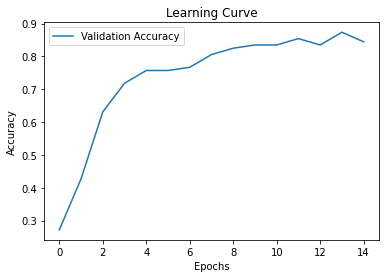

In [ ]:
fig = plt.figure()
plt.plot(x, val_acc, label = 'Validation Accuracy')
# plt.plot(x, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Learning Curve")
plt.legend()
plt.savefig('learningCurveDigits.svg')
files.download('learningCurveDigits.svg')
plt.show()

In [ ]:
val_acc_asl = [ 0.1867, 0.3156, 0.4131, 0.5409, 0.5749, 0.6416, 0.6858, 0.7393, 0.7515, 0.7651, 0.7933, 0.7966, 0.8117, 0.8237, 0.8230]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

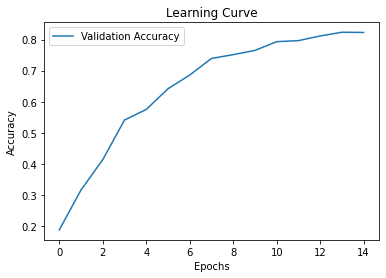

In [ ]:
fig = plt.figure()
plt.plot(np.arange(0, 15, 1).tolist(), val_acc_asl, label = 'Validation Accuracy')
# plt.plot(x, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Learning Curve")
plt.legend()
plt.savefig('learningCurveASL.svg')
files.download('learningCurveASL.svg')
plt.show()

In [ ]:
train_loss_d_to_asl = [3.0756, 2.4962, 2.1551, 1.8978, 1.7103, 1.5356, 1.3976, 1.2758, 1.1708, 1.0950, 1.0074, 0.9471, 0.9061, 0.8337, 0.7520]
val_loss_d_to_asl = [2.7105, 2.3526, 2.1303, 1.8864, 1.7262, 1.6175, 1.4928, 1.3974, 1.3164, 1.2509, 1.2244, 1.1428, 1.1056, 1.0365, 0.9809]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

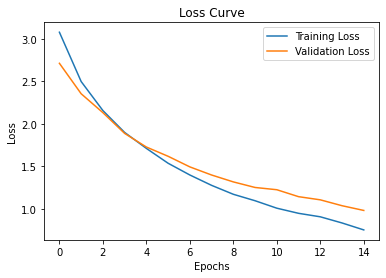

In [ ]:
fig = plt.figure()
plt.plot(x, train_loss_d_to_asl, label = 'Training Loss')
plt.plot(x, val_loss_d_to_asl, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Curve")
plt.legend()
plt.savefig('lossCurveDtoASL.svg')
files.download('lossCurveDtoASL.svg')
plt.show()